In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import lstsq
from sklearn.model_selection import train_test_split
import cvxpy as cp

In [118]:
def train_night(q_hp, delta_T_i, delta_T_a, delta_t):
    """Solve inner CVXPY problem for a given C and return parameters + metrics."""
    N = len(delta_T_i)
    
    # Expression
    X1_n = delta_T_a*delta_t
    X2_n = q_hp
    X3_n = delta_t * np.ones_like(X1_n)
    
    Y_n = delta_T_i
     
    X_n = np.column_stack([X1_n, X2_n, X3_n])
    theta_n, residuals_n, rank, s = lstsq(X_n, Y_n)

    # recover parameters
    alpha, beta, gamma = theta_n   # [1/(C·R), 1/C, w_n/C]
    C     = 1.0 / beta
    R_a   = beta / alpha
    w_n   = gamma * C
    rmse_n  = np.sqrt(residuals_n / len(Y_n))

    return C, R_a, w_n, rmse_n

def train_day(C,R_a, q_hp, q_solar, delta_T_i, delta_T_a, delta_t):
    N = len(delta_T_i)
    
    #-----Day training-------
    Y_day_1 = C * delta_T_i
    Y_day_2 = delta_T_a / R_a * delta_t
    Y_day_3 = q_hp
    
    Y_day = Y_day_1 - Y_day_2 - Y_day_3
    
    X_2 = q_solar 
    X_1 = delta_t * np.ones_like(X_2) # constant term
    
    X_day = np.column_stack([X_1, X_2])
    
    theta_d, residuals_d, rank_d, s_d = lstsq(X_day, Y_day)
    
    w_d   = theta_d[0]
    w_s = theta_d[1]
    rmse_d  = np.sqrt(residuals_d / len(Y_day))

    return w_s, w_d, rmse_d

In [119]:
df_data = pd.read_parquet("training_data/initial_dataset.parquet")
df_train_detached = pd.read_parquet(
    "training_data/data_detached_with_weather.parquet")
type(df_data)
type(df_train_detached)
df_train_detached

,Property_ID,Timestamp,half-hour,Boiler_Energy_Output,Circulation_Pump_Energy_Consumed,Heat_Pump_Energy_Output,Whole_System_Energy_Consumed,External_Air_Temperature,Heat_Pump_Heating_Flow_Temperature,Heat_Pump_Return_Temperature,...,Postcode,Time,Temperature,FeelsLike,Humidity,Dew,Precipitation,SolarRadiation,SolarEnergy,Windspeed
0,EOH0279,2020-10-26 00:00:00,00:00:00,NaN,0.000,0.000,0.008,9.38,23.14,23.35,...,EH22,00:00:00,8.90,6.10,79.75,5.6,0.154,0.0,0.0,19.30
1,EOH1703,2020-10-26 00:00:00,00:00:00,NaN,0.013,0.242,0.078,7.08,25.04,24.04,...,NE15,00:00:00,7.00,4.30,81.71,4.1,0.170,0.0,0.0,14.30
2,EOH1703,2020-10-26 00:30:00,00:30:00,NaN,0.029,0.622,0.212,6.83,25.43,24.23,...,NE15,00:30:00,6.95,4.05,81.93,4.1,0.085,0.0,0.0,15.85
3,EOH0279,2020-10-26 00:30:00,00:30:00,NaN,0.000,0.000,0.019,9.33,22.54,22.80,...,EH22,00:30:00,8.85,6.30,79.94,5.6,0.077,0.0,0.0,17.00
4,EOH0279,2020-10-26 01:00:00,01:00:00,NaN,0.000,2.730,0.967,9.21,35.27,30.93,...,EH22,01:00:00,8.80,6.50,80.13,5.6,0.000,0.0,0.0,14.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
505054,EOH3154,2023-09-29 00:00:00,00:00:00,NaN,0.000,44801.768,14989.282,12.44,18.87,50.46,...,EH15,00:00:00,12.80,12.80,90.62,11.3,0.333,0.0,0.0,16.00
505055,EOH1637,2023-09-29 00:00:00,00:00:00,NaN,203.311,43996.381,13830.005,12.17,16.70,16.53,...,PH7,00:00:00,13.20,13.20,86.43,11.0,0.004,0.0,0.0,17.00
505056,EOH2329,2023-09-29 00:00:00,00:00:00,NaN,31.139,14128.100,5775.602,12.44,24.80,26.31,...,EH4,00:00:00,12.90,12.90,90.75,11.4,0.378,0.0,0.0,15.00
505057,EOH2675,2023-09-29 00:00:00,00:00:00,NaN,212.928,59675.471,19247.887,12.44,14.82,14.85,...,EH9,00:00:00,13.00,13.00,93.04,11.9,0.024,0.0,0.0,24.30


In [120]:
unique_ids = df_train_detached["Property_ID"].unique()

df_house = pd.read_csv('training_data/home_characteristics.csv')

# List of columns to check for missingness
cols = [
    "Bedrooms", "Floor_Height", "Habitable_Rooms", "House_Age",
    "House_Form", "No_Storeys", "No_Underfloor",
    "Total_Floor_Area", "Wall_Type", "MCS_DHWAnnual","HP_Size_kW",
    "HP_Installed", "House_SAP"
]

df_house_train = {}
for id_use in unique_ids:
    df_house_train[id_use] = df_house[df_house["Property_ID"] == id_use]

In [121]:
missing_counts = df_house[df_house["Property_ID"].isin(unique_ids)][["Floor_Height", "Total_Floor_Area"]].isna().sum()
print(missing_counts)


Floor_Height        0
Total_Floor_Area    0
dtype: int64


In [122]:
id_use = unique_ids[0]

trained_params = pd.DataFrame(index=["Floor Area", "No_Storeys", "Wall_Type",
                                     "HP_Type", "House_SAP",
                                     "C", "R_a", "w_s", "w_d", "w_n",
                                     "rmse_d","rmse_n"])

df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()
df_single = df_single.set_index('Timestamp')

#time range
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_mid_end = pd.to_datetime("2022 5 30 23:59:59")
t_mid_start = pd.to_datetime("2022 08 31 00:00:00")
t_end = pd.to_datetime("2022 3 31 23:59:59")
df_index = df_single[df_single.index >= t_start]
df_index = df_index[df_index.index <= t_end]
#df_index = df_index[
#    (df_index.index <= t_mid_end) | (df_index.index >= t_mid_start)]

# Create time index for q_hat arrays
time_index = df_index.index[:-1]
df_q_id = pd.DataFrame(index=time_index)


wall = df_house_train[id_use].Wall_Type.to_string()
storeys = df_house_train[id_use].No_Storeys.to_string()
floor_area = df_house_train[id_use].Total_Floor_Area.to_string()
hp_type = df_house_train[id_use].HP_Installed.to_string()
house_sap = df_house_train[id_use].House_SAP.to_string()

df_single = df_train_detached[
    df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single[
    "Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single[
    "Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] -
     df_single["Internal_Air_Temperature"])

# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
#print("Columns dropped due to high missing values:")
#print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

#print("\nColumns remaining after dropping highly missing columns:")
#print(df_single.columns.tolist())

df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(
    method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy()
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

#print(f"\nNumber of rows dropped after handling NA values (missing for >
# 2 hours): {rows_dropped_after_interpolation}")

# ------ Prepare Training Data ----------
df_heating_single = df_single_processed.copy()

df_heating_annual = df_heating_single[df_heating_single.index >= t_start]
df_heating_annual = df_heating_annual[df_heating_annual.index <= t_end]
#df_heating_annual = df_heating_annual[
#    (df_heating_annual.index <= t_mid_end) | (df_heating_annual
#                                              .index >= t_mid_start)]

    # Extract hour from Timestamp
df_heating_annual_night = df_heating_annual.copy()
df_heating_annual_night['Hour'] = df_heating_annual.index.hour

# Define night and day conditions
# Condition 1: Time is between 10 PM and 6 AM
night_time_condition = (df_heating_annual_night['Hour'] >= 20) | \
                       (df_heating_annual_night['Hour'] < 6)

# Condition 2: Solar Irradiation is 0 (assuming 'SolarRadiation' is the correct column name)
if 'SolarRadiation' in df_heating_annual_night.columns:
    night_solar_condition = (df_heating_annual_night['SolarRadiation'] == 0)
    df_heating_annual_night['is_night'] = night_time_condition & night_solar_condition
else:
    print("\nWarning: 'SolarRadiation' column not found after preprocessing. Cannot use it for night/day split.")
    df_heating_annual_night['is_night'] = night_time_condition # Fallback to just time condition

day_df = df_heating_annual_night[df_heating_annual_night['is_night'] == False]
night_df = df_heating_annual_night[df_heating_annual_night['is_night'] == True]

print(f"\nDay data shape: {day_df.shape}")
print(f"Night data shape: {night_df.shape}")


t_step = 30  # minutes
delta_t = t_step / 60

#Night data

T_a_n = (night_df["External_Air_Temperature"].iloc[:-1]
          .reset_index
       (drop=True).to_numpy())
T_i_n = (night_df["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy())
delta_T_a_n = (
    night_df["Internal_Ambient_Temperature_Diff"].iloc[:-1]
    .reset_index(drop=True).to_numpy())
delta_T_i_n = (night_df["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t)
q_hp_n = (night_df["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy())
q_solar_n = (night_df["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy())
v_wind_n = (night_df["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy())


# Day data
T_a_d = (day_df["External_Air_Temperature"].iloc[:-1]
          .reset_index
       (drop=True).to_numpy())
T_i_d = (day_df["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy())
delta_T_a_d = (
    day_df["Internal_Ambient_Temperature_Diff"].iloc[:-1]
    .reset_index(drop=True).to_numpy())
delta_T_i_d = (day_df["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t)
q_hp_d = (day_df["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy())
q_solar_d = (day_df["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy())
v_wind_d = (day_df["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy())


N_n = len(T_a_n)

# Create time index for in the loop q_hat arrays
time_index = df_heating_annual.index[:-1]
df_q_results = pd.DataFrame(index=time_index)


C,R_a,w_n,rmse_n =  train_night(q_hp_n, delta_T_i_n, delta_T_a_n, delta_t)

w_s,w_d,rmse_d = train_day(C,R_a,q_hp_d,q_solar_d,delta_T_i_d, delta_T_a_d, 
                     delta_t)

trained_params[id_use] = [floor_area, storeys, wall, hp_type, house_sap, 
                          C,R_a,w_s,w_d,w_n,rmse_d,rmse_n]
    
    


Day data shape: (2550, 28)
Night data shape: (1770, 28)


In [123]:
trained_params


,EOH0279
Floor Area,2066 172.33
No_Storeys,2066 2.0
Wall_Type,2066 Cavity_Insulated
HP_Type,2066 ASHP
House_SAP,2066 A
C,5.417097
R_a,4.195915
w_s,-0.001523
w_d,1.334737
w_n,-0.263825


In [124]:
for id_use in df_house_train:
    print(df_house_train[id_use].House_SAP)
    print(df_house_train[id_use].HP_Installed)

2066    A
Name: House_SAP, dtype: object
2066    ASHP
Name: HP_Installed, dtype: object
2381    NaN
Name: House_SAP, dtype: object
2381    ASHP
Name: HP_Installed, dtype: object
1569    C
Name: House_SAP, dtype: object
1569    HT_ASHP
Name: HP_Installed, dtype: object
1692    C
Name: House_SAP, dtype: object
1692    ASHP
Name: HP_Installed, dtype: object
585    C
Name: House_SAP, dtype: object
585    ASHP
Name: HP_Installed, dtype: object
1156    E
Name: House_SAP, dtype: object
1156    HT_ASHP
Name: HP_Installed, dtype: object
1149    D
Name: House_SAP, dtype: object
1149    HT_ASHP
Name: HP_Installed, dtype: object
318    D
Name: House_SAP, dtype: object
318    Hybrid
Name: HP_Installed, dtype: object
736    C
Name: House_SAP, dtype: object
736    HT_ASHP
Name: HP_Installed, dtype: object
76    D
Name: House_SAP, dtype: object
76    ASHP
Name: HP_Installed, dtype: object


RMSE of q_hp: 0.8582002002566639


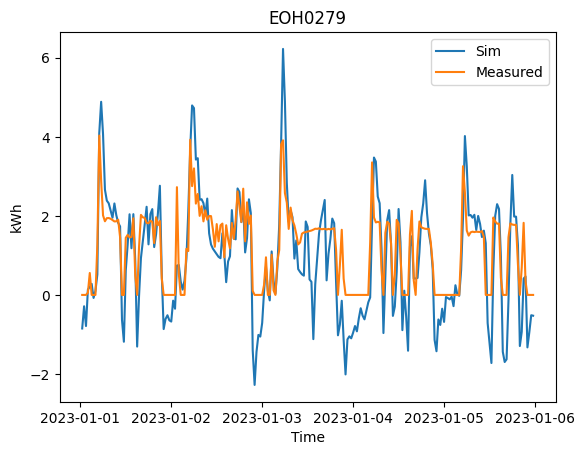

KeyError: 'EOH1703'

In [125]:
# ------- Look at heat supply performance in validation data ------


df_id = trained_params[id_use].copy()
C = df_id.C
R_a = df_id.R_a
w_s= df_id.w_s
w_d = df_id.w_d
w_n = df_id.w_n


df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] - 
     df_single["Internal_Air_Temperature"])

# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
#print("Columns dropped due to high missing values:")
#print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

#print("\nColumns remaining after dropping highly missing columns:")
#print(df_single.columns.tolist())

# 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy() 
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

#print(f"\nNumber of rows dropped after handling NA values (missing for >
# 2 hours): {rows_dropped_after_interpolation}")

# -----EXTRACT SUMMER DATA -------# 
df_heating_single = df_single_processed.copy()

t_start = pd.to_datetime("2023 01 01 00:00:00")
t_end = pd.to_datetime("2023 01 05 23:59:00")
df_q_opt = df_q_results[(df_q_results.index>=t_start) & (df_q_results.index<=t_end)]
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]

# make sure you have an Hour column
df_heating_val = df_heating_val.assign(Hour=df_heating_val.index.hour)

# define night‑time & zero‑solar conditions
night_time = (df_heating_val['Hour'] >= 22) | (df_heating_val['Hour'] < 6)
zero_solar = (df_heating_val['SolarRadiation'] == 0)

# vectorized assignment of w
df_heating_val['w'] = np.where(night_time & zero_solar, w_n, w_d)

w = df_heating_val['w'].iloc[:-1].reset_index(drop=True).to_numpy()

T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 



q_hat_sim = (delta_T_i_val * C -  delta_T_a_val / R_a * delta_t  - w_s *  
        q_solar_val  - w * np.ones(len(T_a_val), )* delta_t )

e_q = q_hat_sim - q_hp_val
rmse_q_val = np.sqrt(np.mean(e_q**2))
print(f"RMSE of q_hp: {rmse_q_val}")

plt.plot(df_heating_val.index[1:],q_hat_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], q_hp_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("kWh")
plt.title(f"{id_use}")
plt.show()

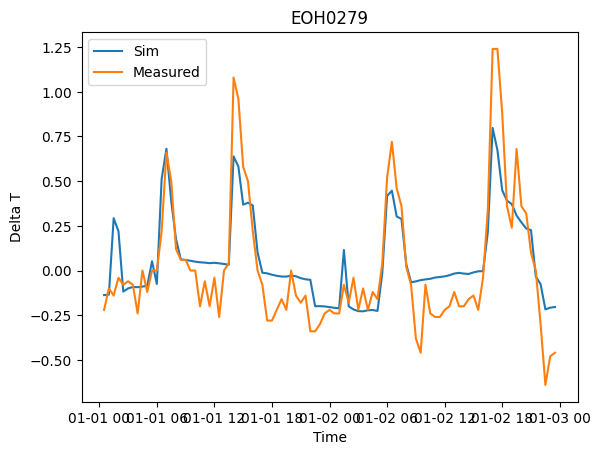

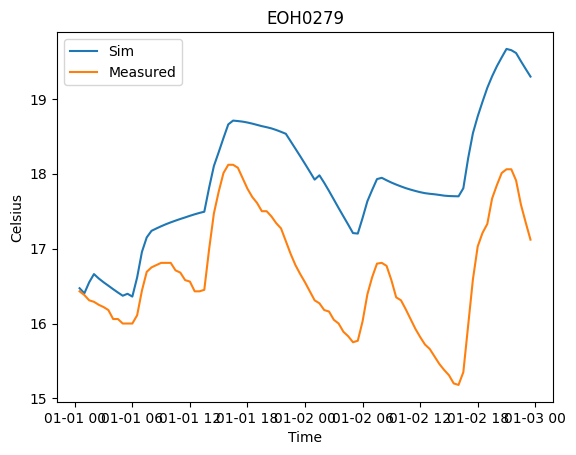

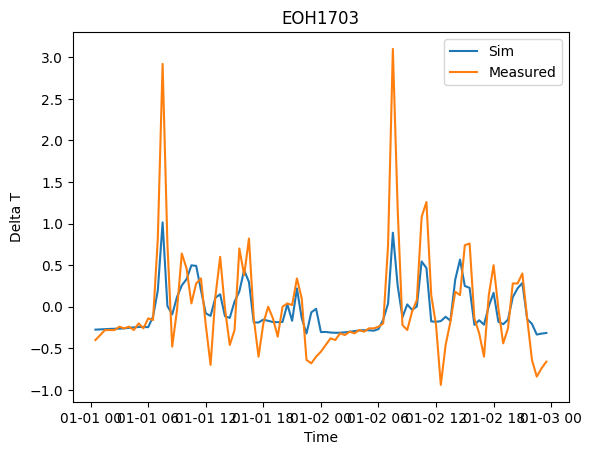

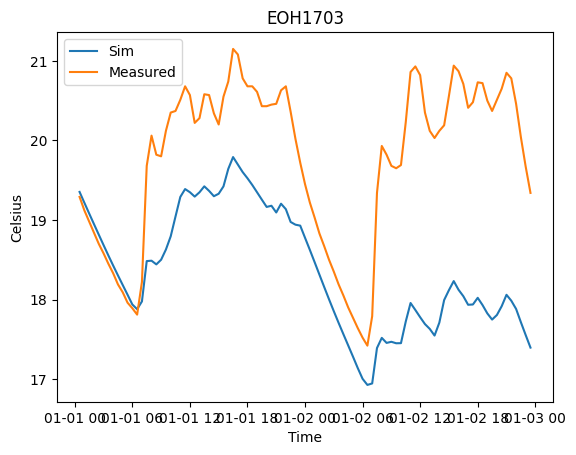

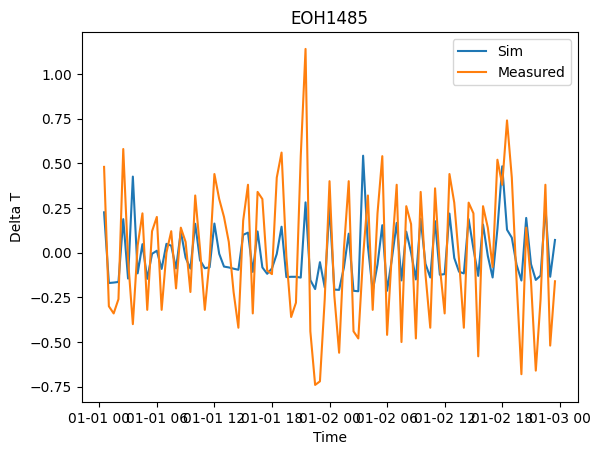

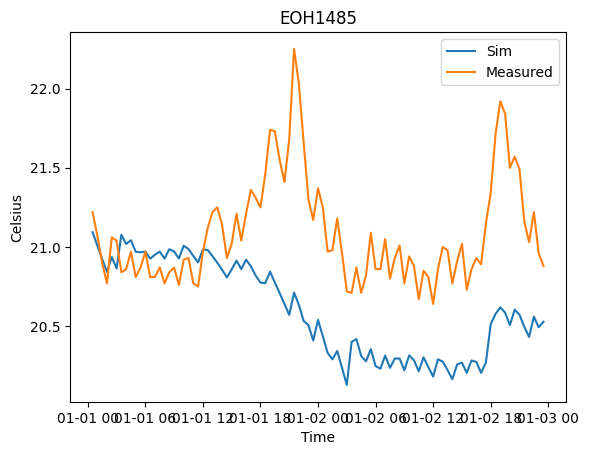

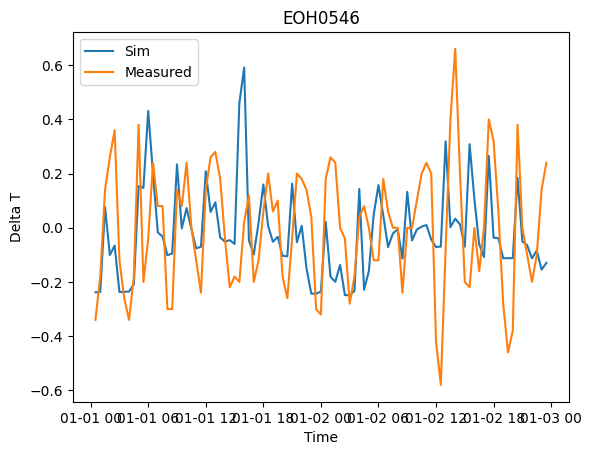

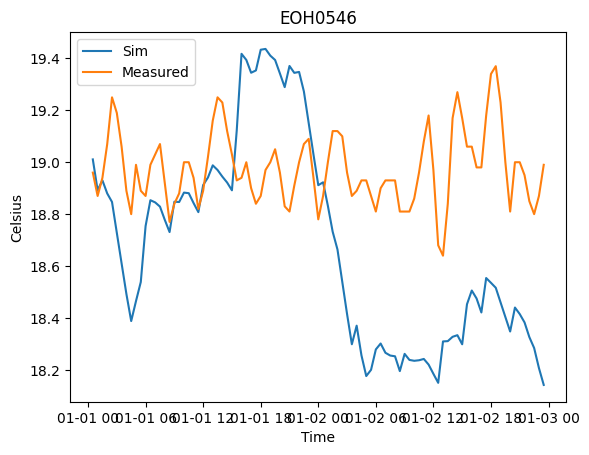

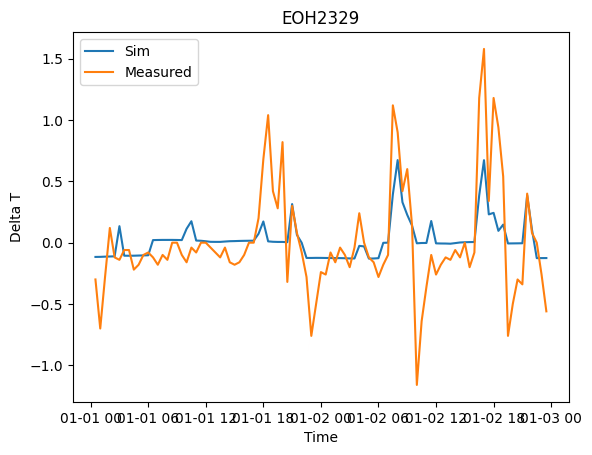

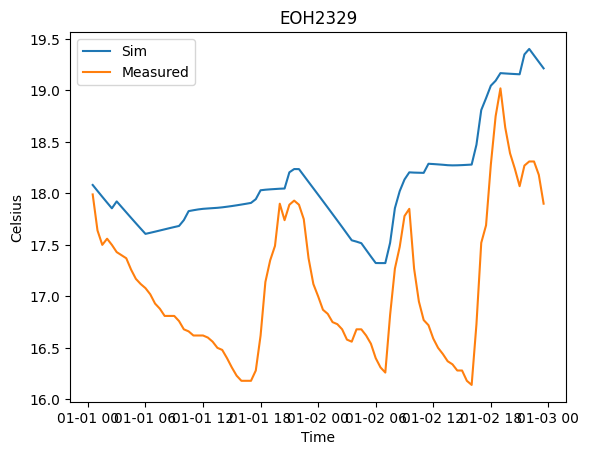

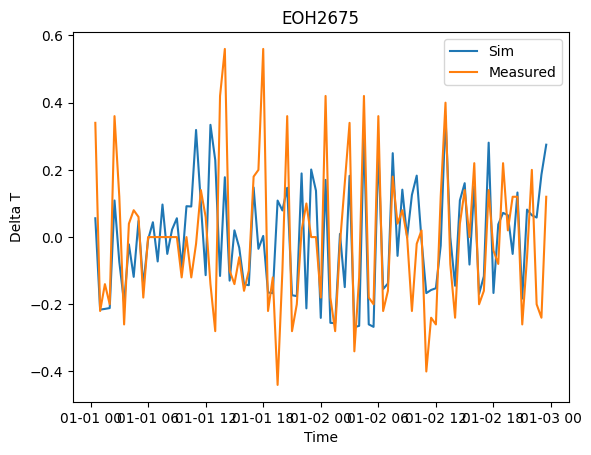

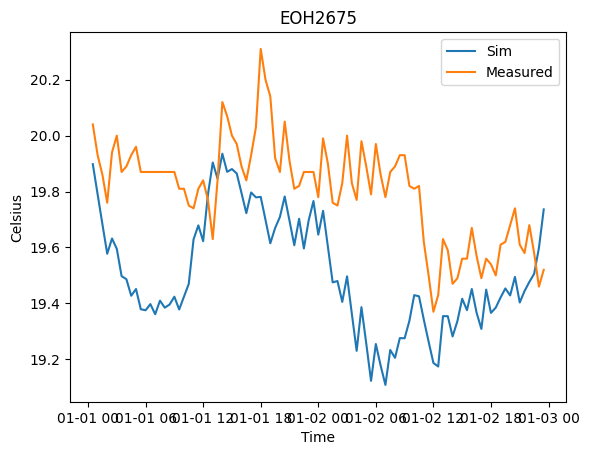

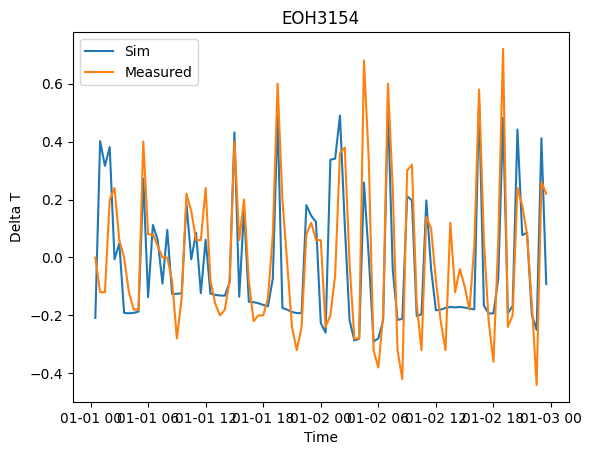

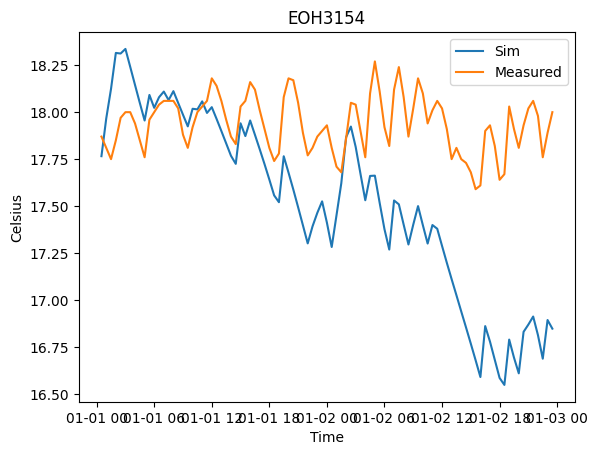

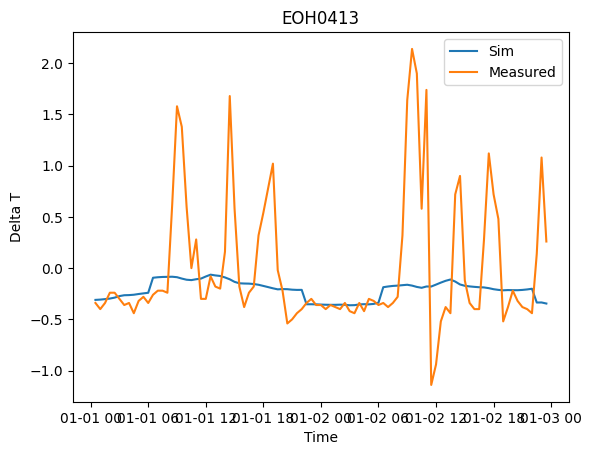

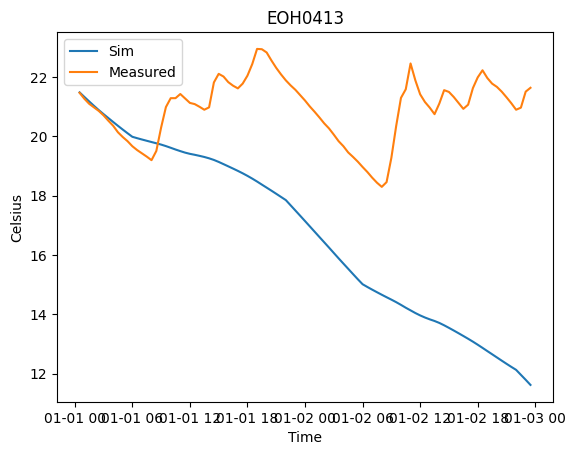

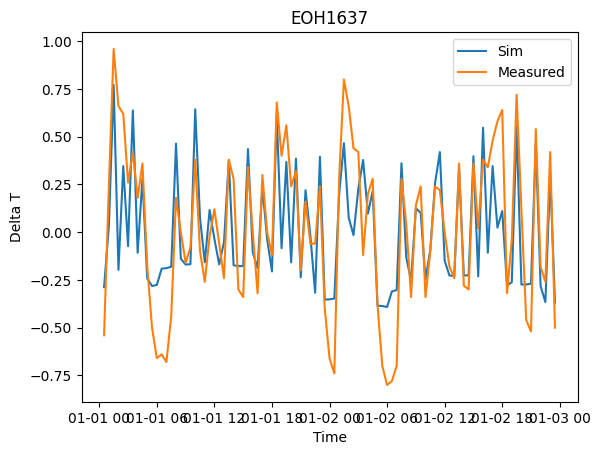

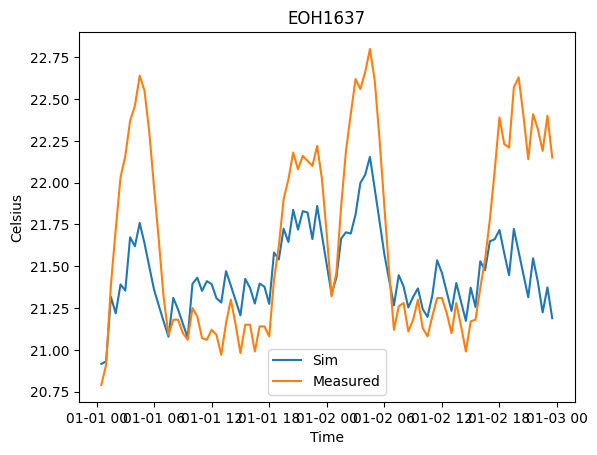

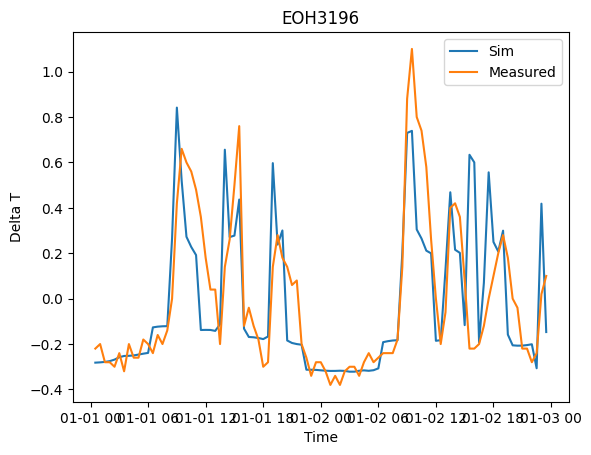

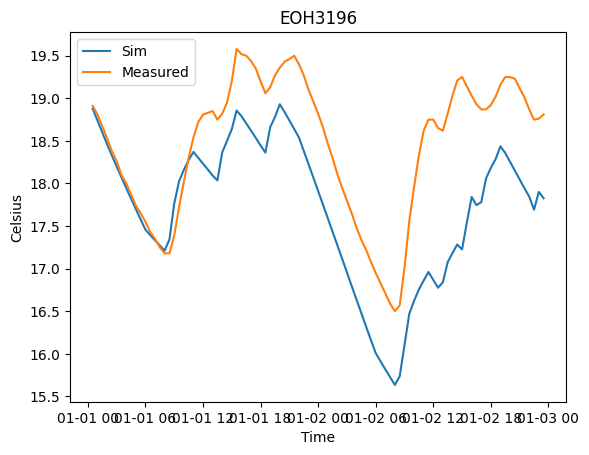

In [116]:
# -----Look at temperature tracking performance in the training --------------

df_id = trained_params[id_use].copy()
C = df_id.C
R_a = df_id.R_a
w_s= df_id.w_s
w_d = df_id.w_d
w_n = df_id.w_n

df_single = df_train_detached[df_train_detached["Property_ID"] == id_use].copy()

#re-adjust Heat Pump Diff and add temp differences
df_single["Heat_Pump_Energy_Output_Diff"] = df_single["Heat_Pump_Energy_Output"].diff()
df_single["Internal_Temperature_Diff"] = df_single["Internal_Air_Temperature"].diff()
df_single["Internal_Ambient_Temperature_Diff"] = \
    (df_single["External_Air_Temperature"] - 
     df_single["Internal_Air_Temperature"])
     


# 1. Drop columns with almost all missing data (e.g., more than 90% missing)
threshold = 0.90 * len(df_single)
df_single_cleaned = df_single.dropna(axis=1, thresh=threshold)
#print("Columns dropped due to high missing values:")
#print(df_single.columns.difference(df_single_cleaned.columns).tolist())

df_single = df_single_cleaned

#print("\nColumns remaining after dropping highly missing columns:")
#print(df_single.columns.tolist())

# 2. Handle missing values: Interpolate if missing for up to 2 hours (4 half-hour intervals), else drop rows
df_single = df_single.set_index('Timestamp')
df_single = df_single.sort_index()

# Apply interpolation with a limit of 4 (for 2 hours of half-hourly data)
numeric_cols = df_single.select_dtypes(include=['number']).columns
df_single_numeric_interpolated = df_single[numeric_cols].interpolate(method='time', limit=4, limit_direction='both')

df_single_interpolated = df_single.copy() 
df_single_interpolated[numeric_cols] = df_single_numeric_interpolated

# After interpolation, drop rows that still contain NaN values (meaning they were missing for > 2 hours)
initial_rows = len(df_single_interpolated)
df_single_processed = df_single_interpolated.dropna()
rows_dropped_after_interpolation = initial_rows - len(df_single_processed)

#print(f"\nNumber of rows dropped after handling NA values (missing for >
# 2 hours): {rows_dropped_after_interpolation}")

# -----EXTRACT SUMMER DATA -------# 
df_heating_single = df_single_processed.copy()

# Validate results
t_start = pd.to_datetime("2022 01 01 00:00:00")
t_end = pd.to_datetime("2022 01 02 23:59:00")
df_q_id_use = df_q_id[(df_q_id.index>=t_start) & (df_q_id.index<=t_end)]
df_heating_val = df_heating_single[df_heating_single.index>=t_start]
df_heating_val = df_heating_val[df_heating_val.index<=t_end]

# make sure you have an Hour column
df_heating_val = df_heating_val.assign(Hour=df_heating_val.index.hour)

# define night‑time & zero‑solar conditions
night_time = (df_heating_val['Hour'] >= 22) | (df_heating_val['Hour'] < 6)
zero_solar = (df_heating_val['SolarRadiation'] == 0)

# vectorized assignment of w
df_heating_val['w'] = np.where(night_time & zero_solar, w_n, w_d)

w = df_heating_val['w'].iloc[:-1].reset_index(drop=True).to_numpy()

T_a_val = (df_heating_val["External_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
T_i_val = (df_heating_val["Internal_Air_Temperature"].iloc[:-1].reset_index
       (drop=True).to_numpy()) 
delta_T_a_val = (df_heating_val["Internal_Ambient_Temperature_Diff"].iloc[:-1]
             .reset_index(drop=True).to_numpy()) 
delta_T_i_val = (df_heating_val["Internal_Temperature_Diff"].iloc[1:]
             .reset_index(drop=True).to_numpy() / delta_t) 
q_hp_val = (df_heating_val["Heat_Pump_Energy_Output_Diff"].iloc[:-1]
        .reset_index(drop=True).to_numpy()) 
q_solar_val = (df_heating_val["SolarRadiation"].iloc[:-1].reset_index
           (drop=True).to_numpy()) 
v_wind_val = (df_heating_val["Windspeed"].iloc[:-1].reset_index(drop=True)
          .to_numpy()) 


delta_T_i_sim = (delta_T_a_val / R_a *delta_t + q_hp_val + w_s* q_solar_val+ w * np
                 .ones(len(T_a_val), )* delta_t) / C

T_i_sim = np.zeros_like(T_i_val)
T_i_prev = T_i_val[0]
for i in range(len(delta_T_i_sim)):
    T_i_sim[i] = T_i_prev + delta_T_i_sim[i]*delta_t
    T_i_prev = T_i_sim[i]


plt.plot(df_heating_val.index[1:],delta_T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], delta_T_i_val, label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Delta T")
plt.title(f"{id_use}")
plt.show()

plt.plot(df_heating_val.index[1:],T_i_sim, label = "Sim")
plt.plot(df_heating_val.index[1:], df_heating_val["Internal_Air_Temperature"]
         .iloc[1:].reset_index
       (drop=True).to_numpy(), label = "Measured")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Celsius")
plt.title(f"{id_use}")
plt.show()